# Import libraries

In [1]:
# !pip install matplotlib_venn

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib_venn as venn
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

## Define function

In [41]:
def sentiment_analyze(text):
    ''' Function to return compound sentiment score each sentence
    
    Parameter : text  = sentence 
    Return : score of each sentence
    
    '''
    # Instantiate 
    sent = SentimentIntensityAnalyzer()
    score = sent.polarity_scores(text)['compound']
    return score


In [42]:
def count_stopwords(text):
    ''' Function to return number of stopwords in each sentence
    
    Parameter : text  = sentence 
    Return : number of stopwords in each sentence'''
    stop_words = set(stopwords.words('english'))
    # tokenize only word

    tokenizer =  RegexpTokenizer(pattern='\w+')
    word_tokens = tokenizer.tokenize(text)
    # loop through tokenized word and record only stop word into list.
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)


In [43]:
def count_punctuations(text):
    ''' Function to return number of punctuation in each sentence
    
    Parameter : text  = sentence 
    Return : number of punctuations in each sentence
    
    '''
    punctuations='!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    hv_punc = {}
    for i in punctuations:
        # keep number of each punctuation in dictionary
        hv_punc[str(i)+' count']=text.count(i)
    return sum(hv_punc.values())


In [44]:

def venn_digram(dict_dep,dict_vent):
    '''Return ven diagram of matched dictionary
    
    Parameter: dict_dep,dict_vent = any of dictionary contain objects that want to be match and plot ven diagram
    Return:    ven diagram
    
    '''
    
    
    fig,ax = plt.subplots(4,1, figsize=(25,25))
    
    collection = {}
        
    # loop until the last gram (1-4)
    for k in range (4):            
        # zip each gram from each group together and keep in dictionary
        collection = list(zip(collect_dep[k+1],collect_vent[k+1]))

        
        # Define 2 sets
        A = set(collection[0][0])
        B = set(collection[0][1])

# Create and instance of a venn diagram with 2 areas
        diagram = venn.venn2([A, B], ("Depression", "Venting"),ax=ax[k],set_colors=['r','b'])


# Set text content of areas
        diagram.get_label_by_id("10").set_text("\n".join(A - B))
        diagram.get_label_by_id("01").set_text("\n".join(B - A))
        if "\n".join(A & B) == '':
            continue
        else:
            diagram.get_label_by_id("11").set_text("\n".join(A & B))

                

# Data import

In [45]:
# read data
df = pd.read_csv('../data/df_raw_o_d.csv')

In [46]:
df.head()

,title,selftext,subreddit
0,We have persistent scammers preying on this co...,"Folks, a reminder that [Rule 3](/r/offmychest/...",offmychest
1,"Thought he ghosted me, turns out he died.",I met H 16 years ago while visiting my friend ...,offmychest
2,Goodbye Everyone.,"Hello everyone, I have decided to post on here...",offmychest
3,My weird sexual fetish is DESTROYING me mentally,First of all I am not a native speaker so forg...,offmychest
4,I’ll never understand why my dad chose his new...,"For context, my dad was a loving, doting and c...",offmychest


In [47]:
# check shape
df.shape

(3974, 3)

In [48]:
# No NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      3974 non-null   object
 1   selftext   3974 non-null   object
 2   subreddit  3974 non-null   object
dtypes: object(3)
memory usage: 93.3+ KB


In [49]:
df = df.drop_duplicates() 

In [50]:
# check shape after drop duplicates
df.shape

(1863, 3)

In [51]:
# y - values
df['subreddit'].value_counts()

depression    975
offmychest    888
Name: subreddit, dtype: int64

In [52]:
# baseline score
df['subreddit'].value_counts(normalize=True).mul(100).round(2)

depression    52.33
offmychest    47.67
Name: subreddit, dtype: float64

In [53]:
# map Depression = 1, Vent = 0
df['subreddit'] = df['subreddit'].map({'offmychest':0,'depression':1})

# Feature engineering

In [54]:
# create column called 'text' which contain title + selftext
df['text'] = df['title']+ ' '+ df['selftext'] 

In [55]:
# Clean amp word out of our dataset
# df["text"] = df["text"].map(lambda x: x.replace('amp;#x200B' , ' '))
df["text"] = df["text"].map(lambda x: x.replace('amp' , ' '))

In [56]:
# Clean depression word out of our dataset --- the reason will shown at the last of the notebook
df["text"] = df["text"].map(lambda x: x.replace('depression' , ''))
df["text"] = df["text"].map(lambda x: x.replace('depressed' , ''))


#### Features creation : `text_length`, `word_count`, `sentiment score`, `stopwords count` , `punctuations count`

In [57]:
# create column text_length
df['text_length'] = df['text'].map(lambda x : len(x))

In [58]:
# split words and count
df['text_word_count'] = df['text'].apply(lambda x : len(x.split(' ')))


# Instantiate tokenizer with regexp and tokenized. Then, count.
tokenizer =  RegexpTokenizer(pattern='\w+')
df['token_\w+_count'] = df['text'].apply(lambda x : len(tokenizer.tokenize(x.lower())))

<AxesSubplot: >

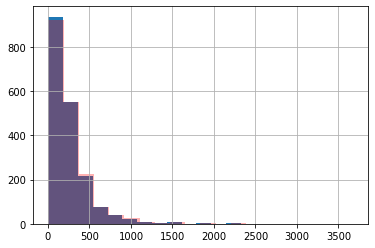

In [59]:
# Compare the difference between split and tokenize
df['text_word_count'].hist(bins=20)
df['token_\w+_count'].hist(bins=20,color='red',alpha=0.3)

# not really different, can use either.

In [60]:
# Check sentiment analysis (take some seconds)
df['sentiment'] = df['text'].apply(lambda x : sentiment_analyze(x))

In [61]:
# Create column count stopwords
df['count_stopwords'] = df['text'].apply(lambda x : count_stopwords(x))

In [62]:
# Create column count punctuations
df['count_punc'] = df['text'].apply(lambda x : count_punctuations(x))

---

In [63]:
df.groupby('subreddit')['sentiment'].mean()

# Depression person seem to be more negative sentiment

subreddit
0   -0.032899
1   -0.265947
Name: sentiment, dtype: float64

- Depression person seem to type negative sentiment

In [64]:
df.groupby('subreddit')['count_stopwords'].mean()

subreddit
0    158.009009
1     96.844103
Name: count_stopwords, dtype: float64

- Depression person seem not using much stopwords, maybe they might often refer to third person in their text to much. Different from venting person that may address third person and may cause a lot of stopwords.

- This might not have some impact to model.

In [65]:
df.groupby('subreddit')['count_punc'].mean()

subreddit
0    40.561937
1    26.325128
Name: count_punc, dtype: float64

- Depression person seem not represent their emotion much in their text, which is different from venting person.

<AxesSubplot: >

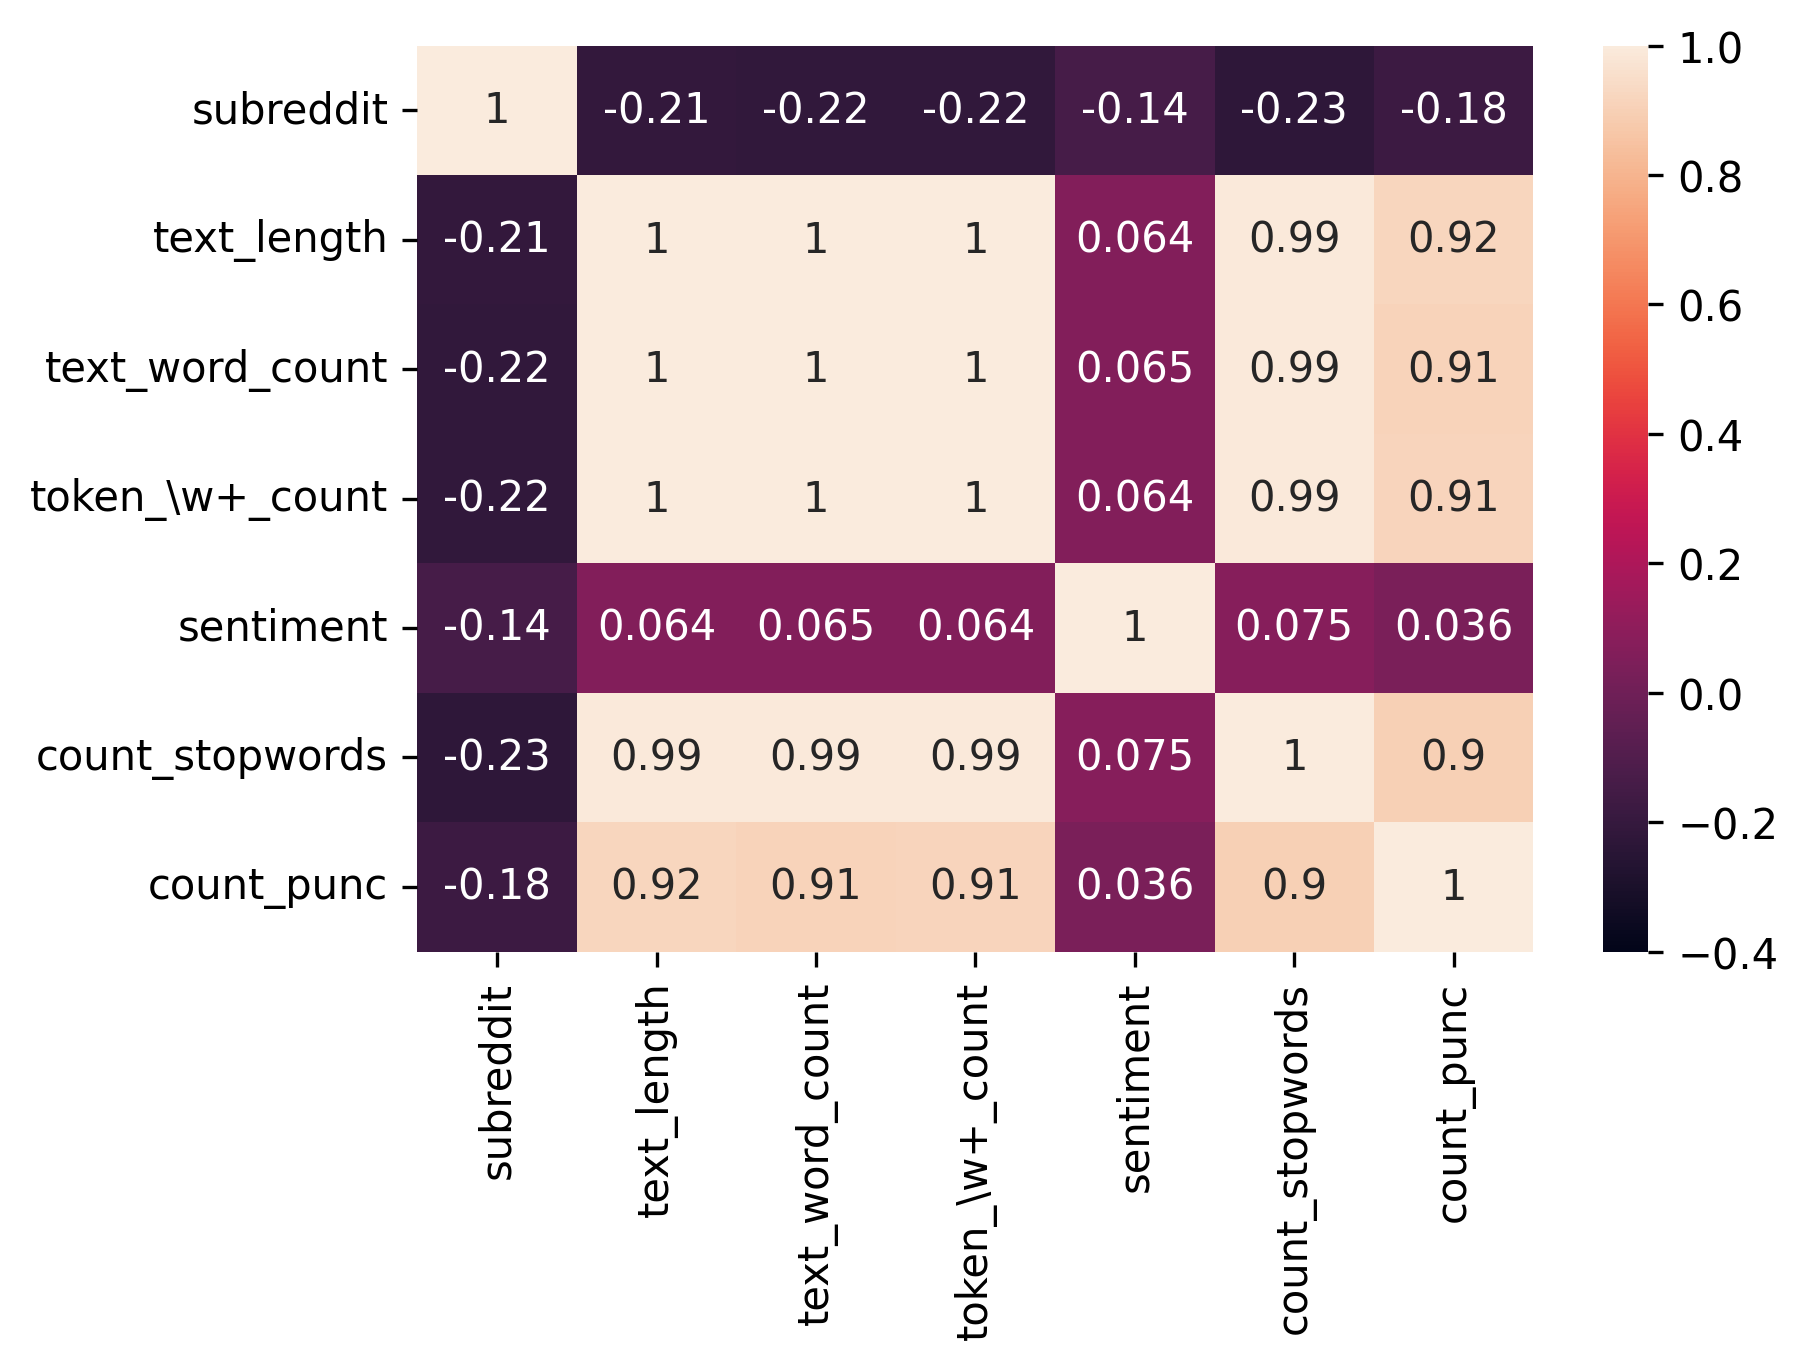

In [149]:
plt.figure(dpi=300)
sns.heatmap(df.corr(),annot=True,vmin=-0.4,vmax =1)

- There are some high collinearlity between the features that created. Assume that countvectorized will count the number of each word in the sentence. So,in technically under the mechanism it might similar to text_length. 
- So, count_stopwords and count_punctuation would not be use as features in the model.

# EDA

In [67]:
# Explor text_length between group
df.groupby('subreddit')['text_length'].agg(['mean','median','count'])

,mean,median,count
subreddit,,,
0,1589.677928,1196.0,888
1,1009.394872,705.0,975


(array([0, 1, 2]),
 [Text(0, 0, 'mean'), Text(1, 0, 'median'), Text(2, 0, 'count')])

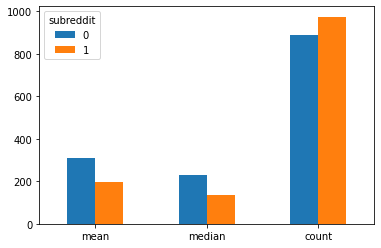

In [68]:
# Visualize the upper cell
df.groupby('subreddit')['text_word_count'].agg(['mean','median','count']).T.plot.bar()
plt.xticks(rotation=0)

- Depression person seem need help from others more often than normal person that just venting. However the post that depression person post seem to be short than normal person that venting about their problem.

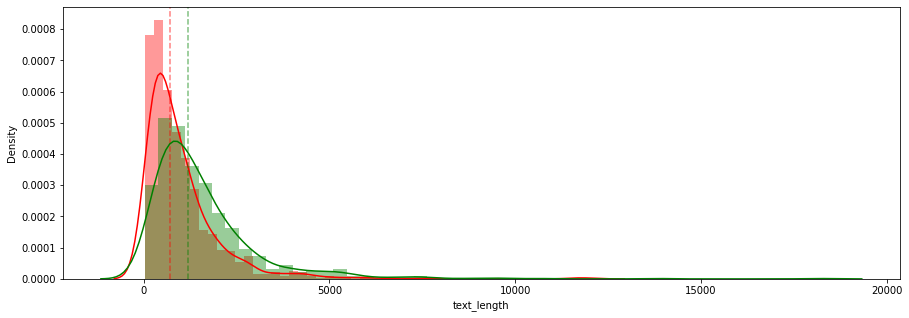

In [69]:
# Visualize the upper cell by distribution plots.

# Filter subreddit groups
dep = df[df['subreddit'] == 1]
vent = df[df['subreddit'] == 0]


# Plot the distribution of text length in each group
fig,ax = plt.subplots(1,figsize=(15,5))
sns.distplot(dep['text_length'],ax=ax,color='red');
ax.axvline(dep['text_length'].median(),color = 'red', linestyle = '--',alpha =0.5)
sns.distplot(vent['text_length'],ax=ax,color='green')
ax.axvline(vent['text_length'].median(),color= 'green',linestyle = '--',alpha=0.5)

(array([0, 1]), [Text(0, 0, 'venting'), Text(1, 0, 'depression')])

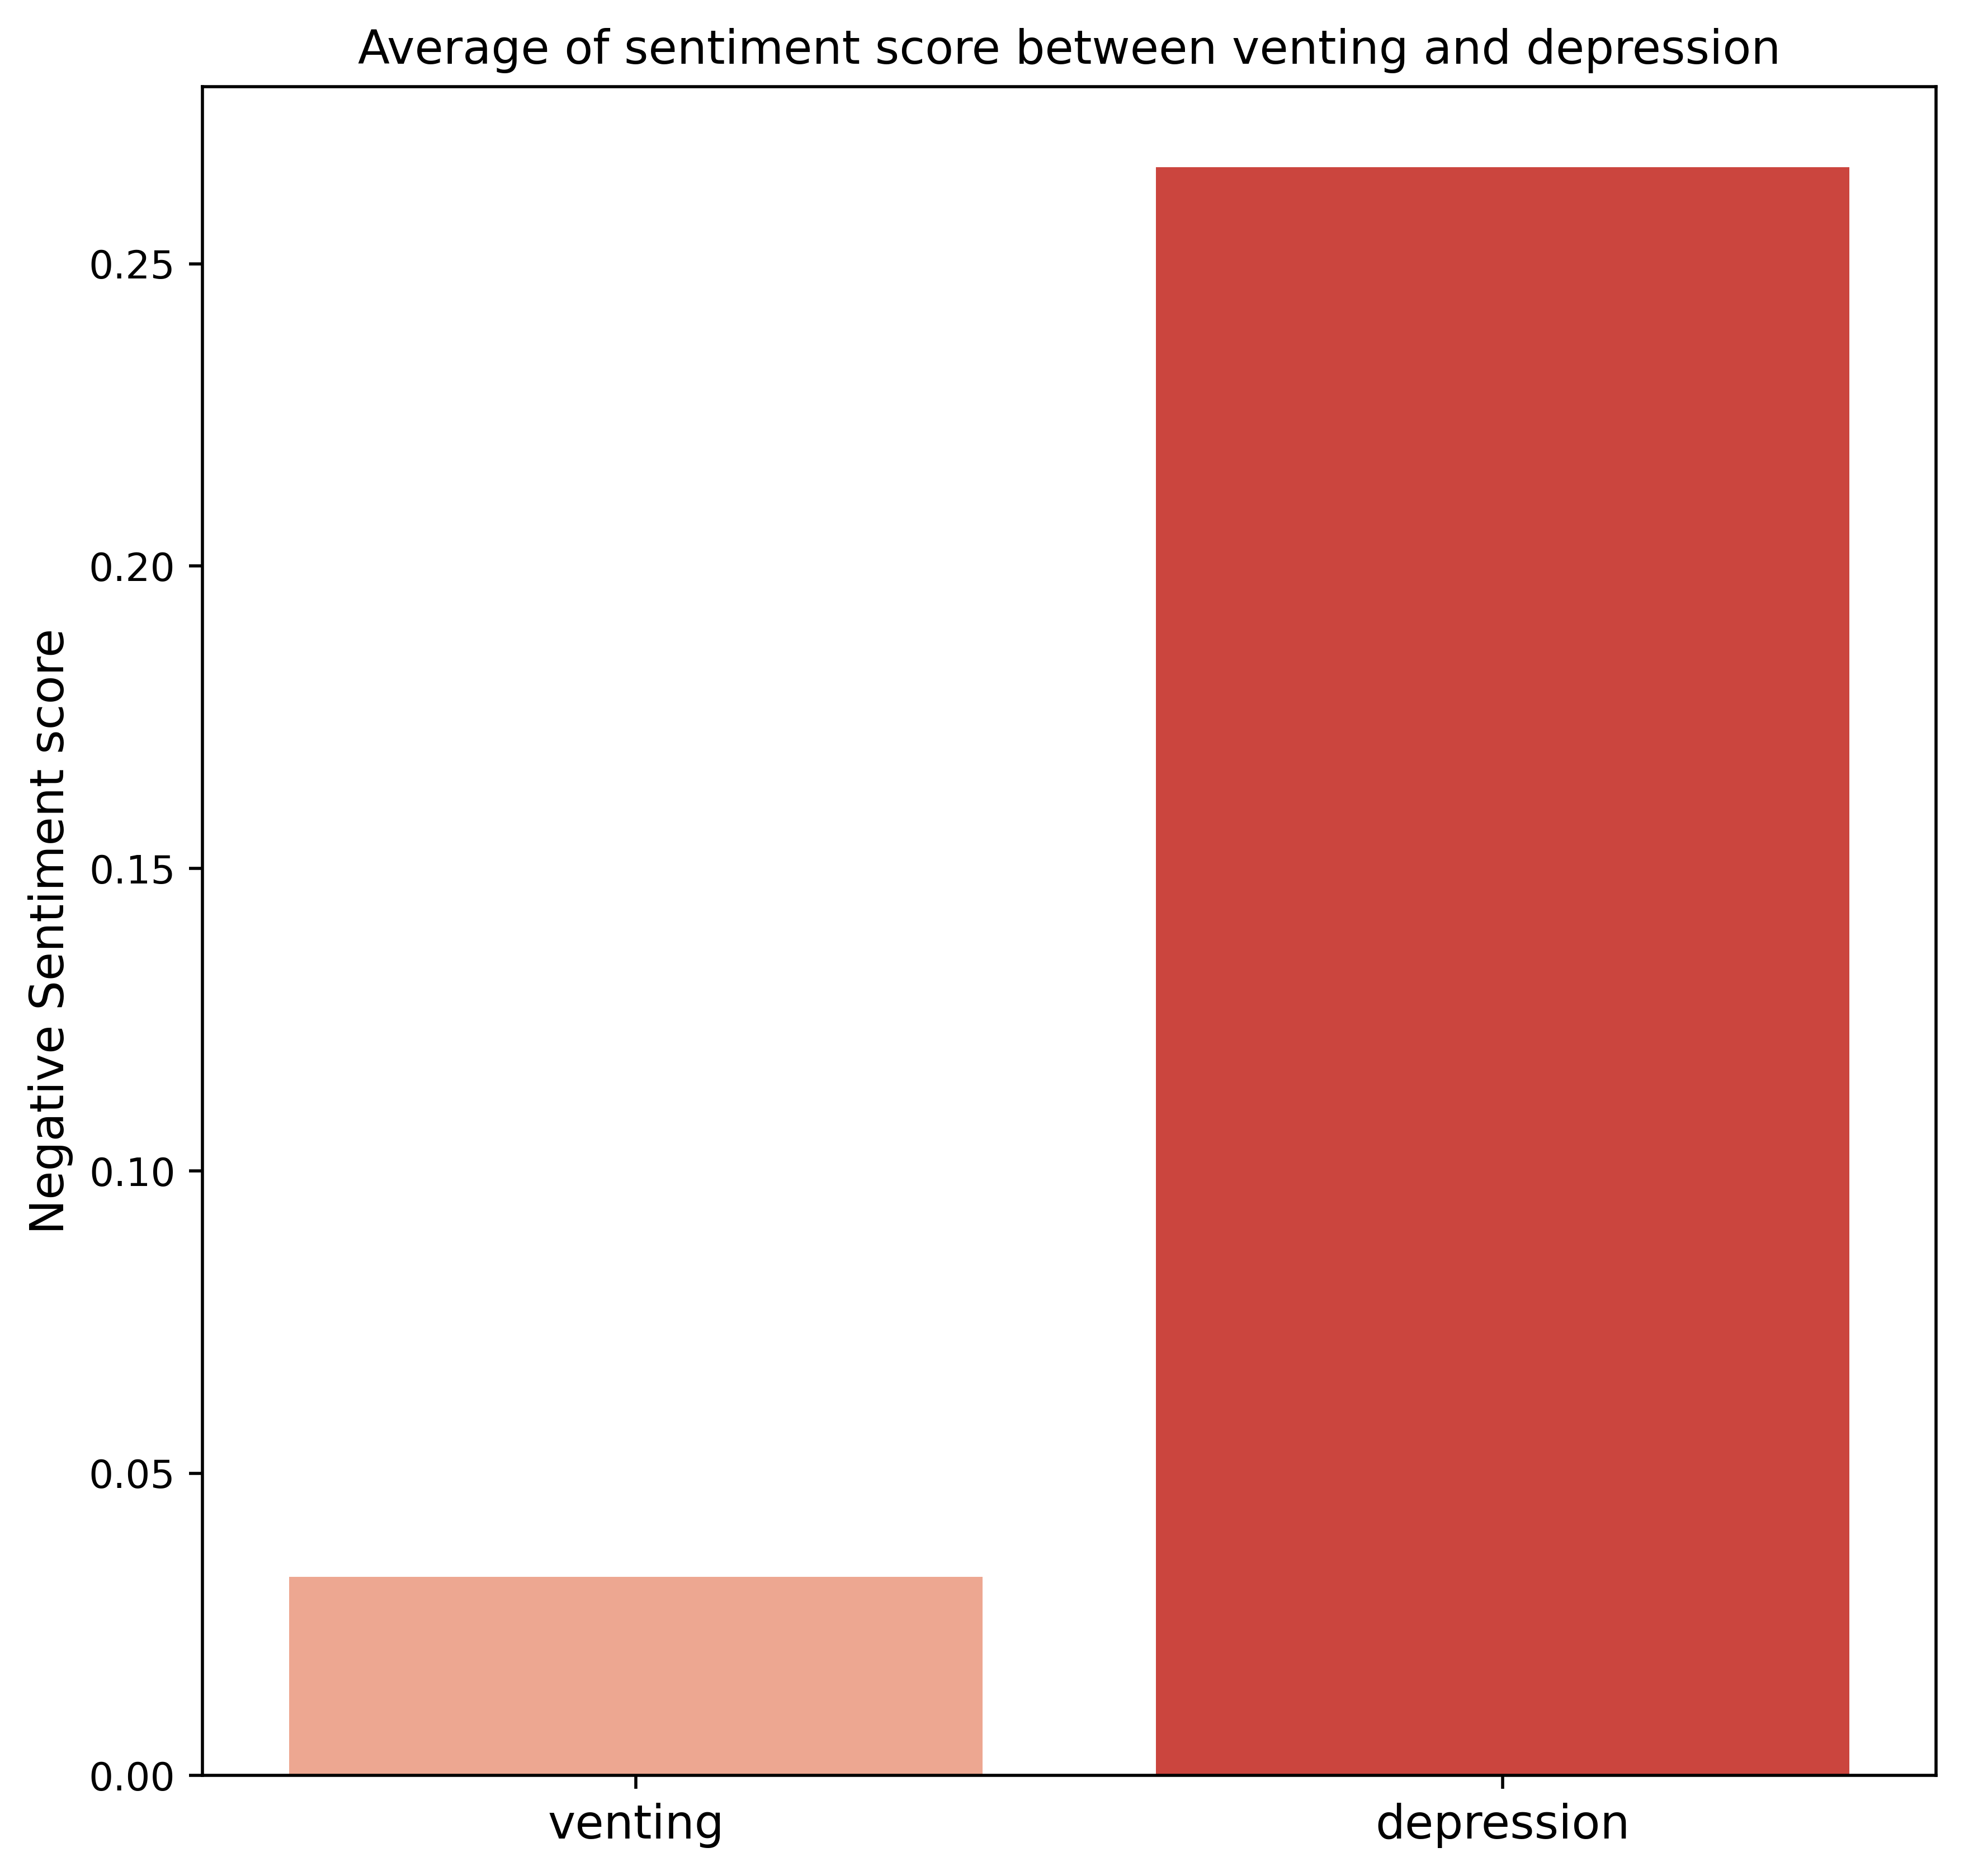

In [148]:
plt.figure(figsize=(8,8),dpi = 500);
sns.barplot(x= ['venting','depression'],y = abs(df.groupby('subreddit')['sentiment'].mean()),palette='Reds')
plt.ylabel('Negative Sentiment score',fontsize= 12)
# plt.yticks(['0','-0.05','0.1'])
plt.title('Average of sentiment score between venting and depression',size =12)
plt.xticks(fontsize = 12)

### Find word important in of both Dep and Vent

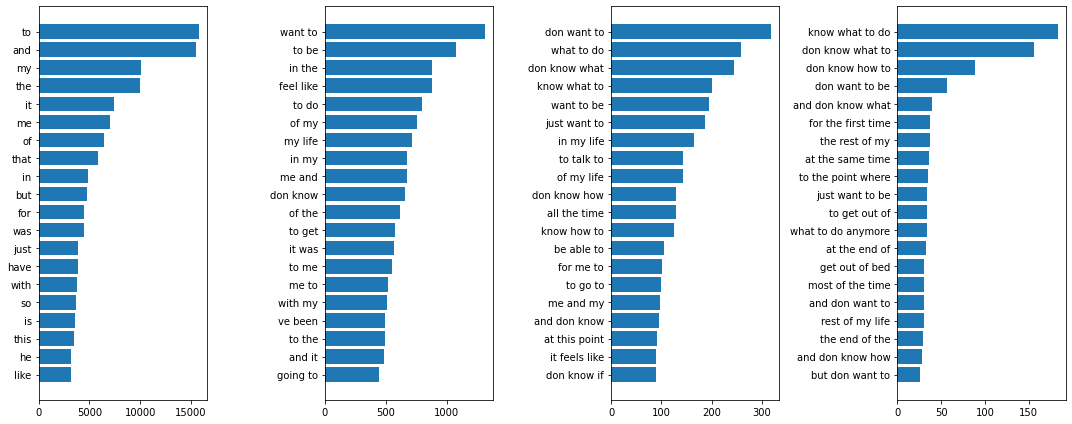

In [71]:
# Let's see word important in the dataframe

fig,ax = plt.subplots(1,4,figsize=(15,6))
for i in range(1,5):
    # loop through each gram 
    cvec = CountVectorizer(ngram_range=(i,i))
    text_cvec = cvec.fit_transform(df['text'])
    # create dataframe to assign vectorized data
    vec = pd.DataFrame(text_cvec.toarray(),columns= cvec.get_feature_names_out())
    # plot horizontal bar by flip index and values to order by decending
    ax[i-1].barh(vec.sum().sort_values(ascending=False)[:20].index[::-1],vec.sum().sort_values(ascending=False)[:20][::-1])
    plt.tight_layout()

### Find word important in depression

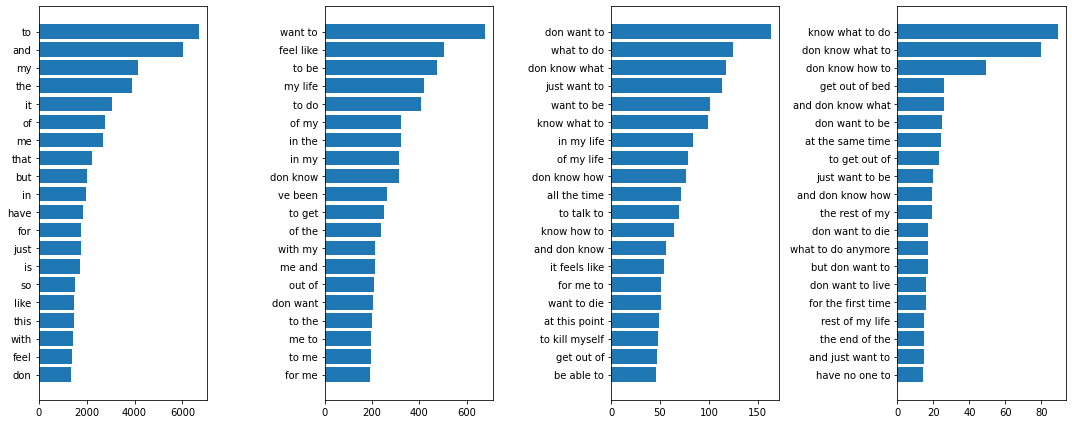

In [72]:
# Select only depression and do the same code
fig,ax = plt.subplots(1,4,figsize=(15,6))
for i in range(1,5):
    cvec = CountVectorizer(ngram_range=(i,i))
    text_cvec = cvec.fit_transform(dep['text'])
    vec = pd.DataFrame(text_cvec.toarray(),columns= cvec.get_feature_names_out())
    ax[i-1].barh(vec.sum().sort_values(ascending=False)[:20].index[::-1],vec.sum().sort_values(ascending=False)[:20][::-1])
    plt.tight_layout()


### Find word important in Vent

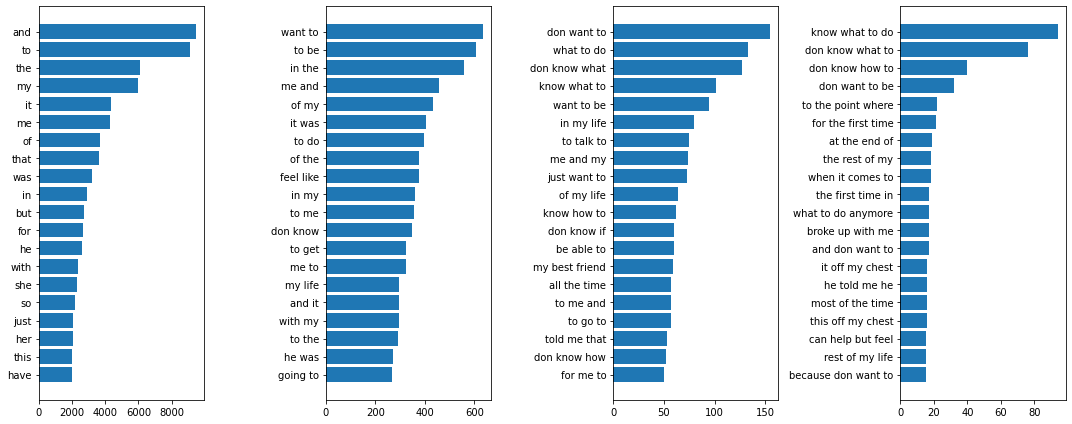

In [73]:
# Select only venting and do the same code

fig,ax = plt.subplots(1,4,figsize=(15,6))
for i in range(1,5):
    cvec = CountVectorizer(ngram_range=(i,i))
    text_cvec = cvec.fit_transform(vent['text'])
    vec = pd.DataFrame(text_cvec.toarray(),columns= cvec.get_feature_names_out())
    ax[i-1].barh(vec.sum().sort_values(ascending=False)[:20].index[::-1],vec.sum().sort_values(ascending=False)[:20][::-1])
    plt.tight_layout()

### Remove stopword and see word important in depression

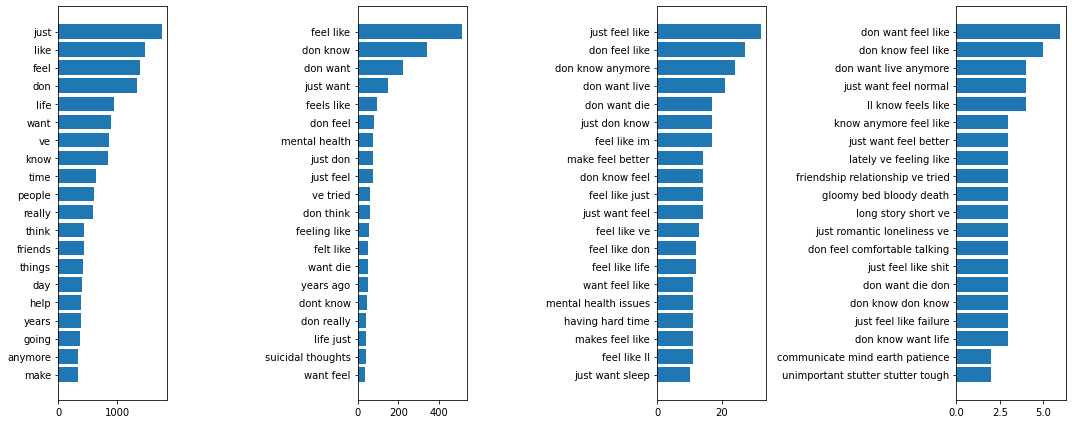

In [74]:
fig,ax = plt.subplots(1,4,figsize=(15,6))
# dictionary for list of most frequent word of depression in each gram.
collect_dep = {}
# loop through until quad-grams.
for i in range(1,5):
    word = []
    cvec = CountVectorizer(ngram_range=(i,i),stop_words='english')
    text_cvec = cvec.fit_transform(dep['text'])
    vec = pd.DataFrame(text_cvec.toarray(),columns= cvec.get_feature_names_out())
    word.append(vec.sum().sort_values(ascending=False)[:20].index)
    # keep the word list into dictionary
    collect_dep[i] = word
    ax[i-1].barh(vec.sum().sort_values(ascending=False)[:20][::-1].index,\
                 vec.sum().sort_values(ascending=False)[:20][::-1])
    plt.tight_layout()

### Remove stopword and see word important in vent

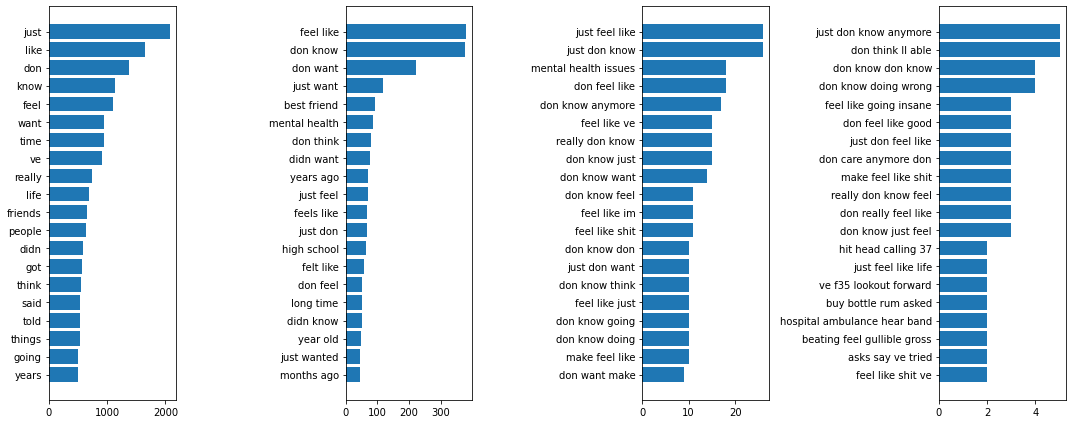

In [75]:
fig,ax = plt.subplots(1,4,figsize=(15,6))
# dictionary for list of most frequent word of venting in each gram.
collect_vent = {}
for i in range(1,5):
    word = []
    cvec = CountVectorizer(ngram_range=(i,i),stop_words='english')
    text_cvec = cvec.fit_transform(vent['text'])
    vec = pd.DataFrame(text_cvec.toarray(),columns= cvec.get_feature_names_out())
    word.append(vec.sum().sort_values(ascending=False)[:20].index)
    collect_vent[i] = word
    ax[i-1].barh(vec.sum().sort_values(ascending=False)[:20].index[::-1],vec.sum().sort_values(ascending=False)[:20][::-1])
    plt.tight_layout()

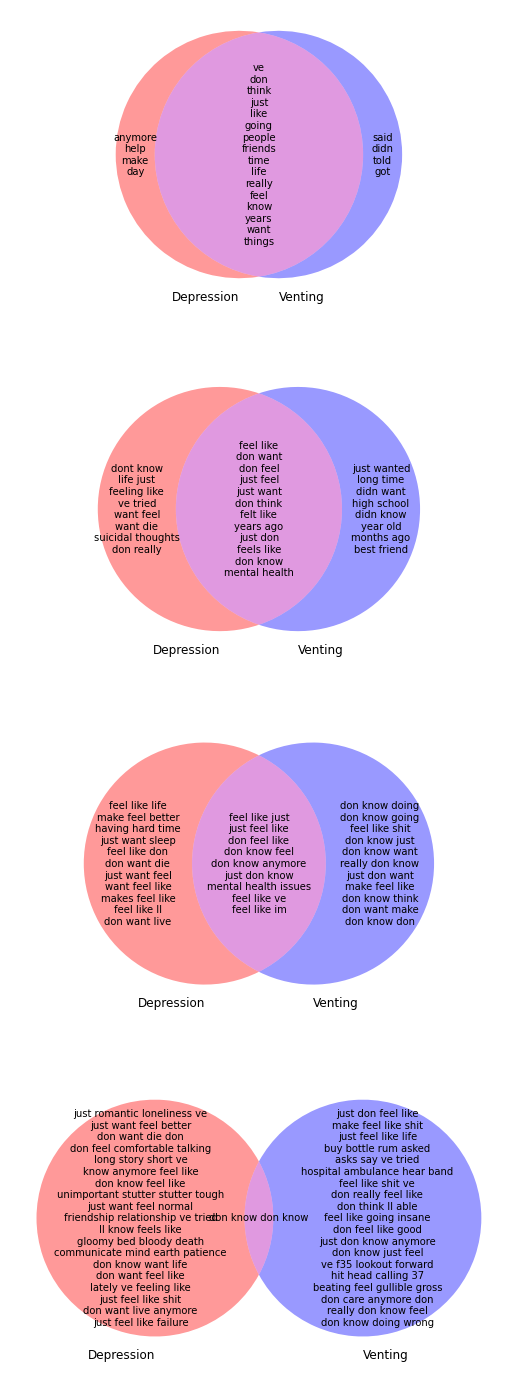

In [76]:
venn_digram(collect_dep,collect_vent)

- There is 'depression' words that appear in depression subreddit that will make model distinguish easily, so need to drop out.

In [77]:
# save cleaned file
df.to_csv('../data/data_cleaned.csv',index=False)